In [19]:
import torch
from torch import nn
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
import json


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using cuda device


In [20]:
from src import get_data_loaders

data_dir = os.path.join(os.getcwd(), 'Data', 'Parsed_Data_Mean')
faste_files_to_load = 37
normalize = False
num_train_val_data = math.inf
num_test_data = math.inf
batch_size = 128
upper_threshold = False
lower_threshold = False
min_coverage = None
max_coverage = None


train_loader, val_loader, test_loader = get_data_loaders(data_dir,
                                                            batch_size=batch_size,
                                                            faste_files_to_load=faste_files_to_load, 
                                                            normalize=normalize, 
                                                            train_val_data_to_load=num_train_val_data, 
                                                            test_data_to_load=num_test_data,
                                                            upper_threshold=upper_threshold,
                                                            lower_threshold=lower_threshold,
                                                            minimum_coverage=min_coverage,
                                                            maximum_coverage=max_coverage)


Loading sequences from sequences.fasta
Loading coverage from SRX9770776.faste
Loading coverage from SRX9770789.faste
Loading coverage from SRX9770788.faste
Loading coverage from SRX9770777.faste
Loading coverage from SRX9770785.faste
Loading coverage from SRX9770782.faste
Loading coverage from SRX9770790.faste
Loading coverage from SRX9770791.faste
Loading coverage from SRX9770783.faste
Loading coverage from SRX9770784.faste
Loading coverage from SRX9770793.faste
Loading coverage from SRX9770786.faste
Loading coverage from SRX9770779.faste
Loading coverage from SRX9770781.faste
Loading coverage from SRX9770780.faste
Loading coverage from SRX9770778.faste
Loading coverage from SRX9770787.faste
Loading coverage from SRX9770792.faste
Loading coverage from SRX9770775.faste
Loading coverage from SRX9770774.faste
Loading coverage from SRX9770773.faste
Loading coverage from SRX391994.faste
Loading coverage from SRX391993.faste
Loading coverage from SRX391992.faste
Loading coverage from SRX391

In [37]:
from src import DeepCNN

# build model
save_dir = os.path.join(os.getcwd(), 'Model_DeepCNN')
os.makedirs(save_dir, exist_ok=True)

num_kernels=[256,128,64] # [32,16,8]
kernel_size=[24,4,4] # [8,4,2]
dropout=0.2
flatten_shape=19648
connect_layer_size=[120, 80]

if True:
    parms = {'num_kernels': num_kernels,
         'kernel_size': kernel_size,
        'dropout': dropout,
        'flatten_shape': flatten_shape,
        'connect_layer_size': connect_layer_size,
    }
    with open(os.path.join(save_dir, 'model_parameters.json'), 'w') as f:
        json.dump(parms, f, indent=4)

    model = DeepCNN(num_kernels=num_kernels,
                    kernel_size=kernel_size,
                    dropout=dropout,
                    output_size=faste_files_to_load,
                    flattened_size=flatten_shape,
                    fc_size=connect_layer_size
                    ).to(device)

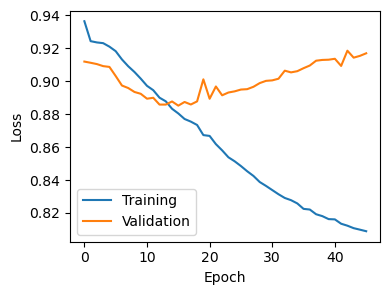

KeyboardInterrupt: 

In [38]:
from src import train_model

lr = 0.0001
epochs = 500
patientce = 50
log_input = True
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.PoissonNLLLoss(log_input=log_input, full=True)
train_model(device, train_loader, val_loader, model, optimizer, loss_fn, epochs, save_dir, patientce)

In [39]:
X, y = next(iter(train_loader))
y_pred = model(X.to(device))
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    if log_input:
        y_p = torch.exp(y_p)
    print(f'{s}: {y_p:.3f}, {y_t:.3f}')

Tissue: Predicted, True
0: 0.151, 0.222
1: 0.196, 0.158
2: 0.078, 0.032
3: 0.099, 0.000
4: 0.083, 0.000
5: 0.161, 0.035
6: 0.175, 0.101
7: 0.176, 0.196
8: 0.166, 0.016
9: 0.169, 0.010
10: 0.191, 0.030
11: 0.076, 0.045
12: 0.107, 0.000
13: 0.178, 0.016
14: 0.079, 0.000
15: 0.062, 0.017
16: 0.076, 0.000
17: 0.168, 0.107
18: 0.155, 0.199
19: 0.169, 0.293
20: 0.163, 0.219
21: 0.201, 0.110
22: 0.153, 0.111
23: 0.215, 0.182
24: 0.231, 0.276
25: 0.224, 0.362
26: 0.142, 0.060
27: 0.231, 0.201
28: 0.137, 0.083
29: 0.218, 0.186
30: 0.186, 0.190
31: 0.194, 0.192
32: 0.217, 0.068
33: 0.250, 0.173
34: 0.185, 0.158
35: 0.259, 0.000
36: 0.235, 0.246


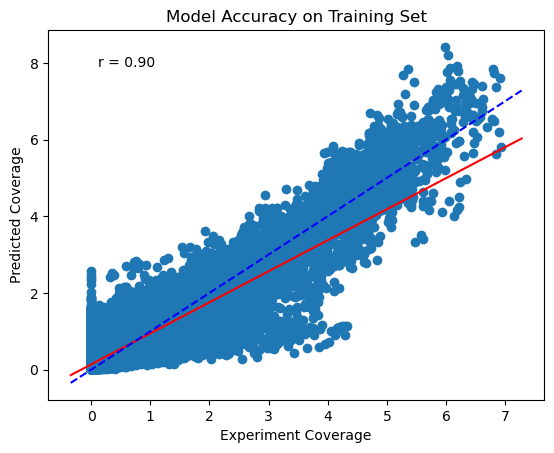

In [40]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)
            
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Training Set")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'TrainingAccuracy.png'), dpi=300)
plt.show()

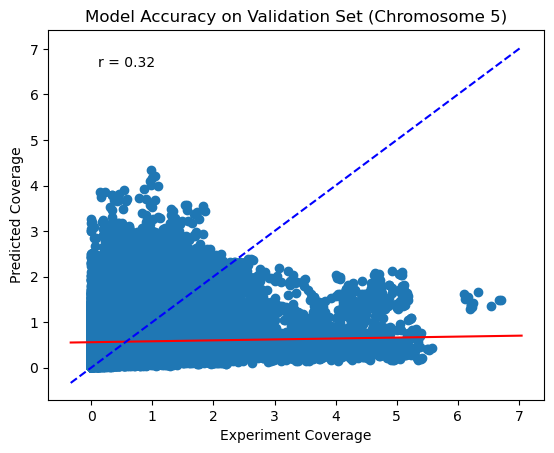

In [41]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(val_loader):
            X = X.to(device)
            y = y.to(device)

            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)

            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Validation Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'ValAccuracy.png'), dpi=300)
plt.show()

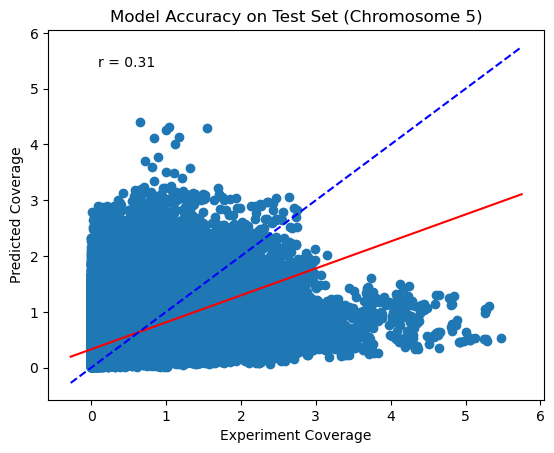

In [42]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)
            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'TestingAccuracy.png'), dpi=300)
plt.show()